In [1]:
work_dir = "/home/alex/study/nn_physical_concepts/"

import os
import sys
os.chdir(work_dir)
sys.path.append(work_dir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scinet import *
import scinet as sc
import scinet.ed_copernicus_elliptic as edc
import scinet.model as model

/home/alex/anaconda3/envs/default-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alex/anaconda3/envs/default-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alex/anaconda3/envs/default-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alex/anaconda3/envs/default-env

### Plotting

In [3]:
def fix_jumps(theta_M):
    """
    Fixes jumps that arise because theta_M is always between -pi and pi
    """
    while True:
        diff = np.abs(theta_M[:, 1:] - theta_M[:, :-1])
        jumps = np.array(np.where(diff > 1.)).T
        if len(jumps) == 0:
            break
        fixed_lines = []
        for x, y in jumps:
            if x in fixed_lines:
                continue
            else:
                fixed_lines.append(x)
            theta_M[x, y + 1:] = theta_M[x, y + 1:] - np.sign(theta_M[x, y + 1] - theta_M[x, y]) * 2 * np.pi
    return theta_M

In [4]:
def copernicus_latent_neurons(net, series_length=50, delta_t=25, steps=50):
    layer = net.state_means
    T_earth = 365.26   
    T_mars = 686.97959
    # the variable eps removes a small window from the plot, such that the discontinuity is not shown
    eps = 0.1
    ss = np.linspace(- T_earth/2 + eps, T_earth/2 - eps, num=steps)
    mm = np.linspace(- T_mars/2 + eps, T_mars/2 - eps, num=steps)
    S, M = np.meshgrid(ss, mm)
    data = edc.copernicus_data(series_length, delta_t=delta_t, t_earth_target=np.ravel(S), t_mars_target=np.ravel(M))[0]
    fig = plt.figure(figsize=(6.0, 2.8))
    fig.tight_layout()
    out = np.array(net.run(data, layer))
    for i in range(len(out[0])):
        zs = out[:, i]
        ax = fig.add_subplot('12{}'.format(i+1), projection='3d')
        ax.view_init(20, 60)
        Z = np.reshape(zs, S.shape)
        surf = ax.plot_surface(S, M, Z, rstride=1, cstride=1, cmap=cm.inferno, linewidth=0)
        ax.set_xlabel(r'$M_E$')
        ax.set_ylabel(r'$M_M$')
        ax.set_zlabel('Latent activation {}'.format(i + 1))
        ax.set_xticks([- T_earth/2.+ eps, 0, T_earth/2.- eps])
        ax.set_yticks([- T_mars/2.+ eps,0, T_mars/2- eps])
        ax.set_xticklabels(['$-\pi$', r'0', r'$\pi$'])
        ax.set_yticklabels(['$-\pi$', r'0', r'$\pi$'])
    return fig

In [5]:
def get_coordinates(phi, a, ecc):    
    r = edc.get_radius(phi,a,ecc)
    return r * np.cos(phi), r * np.sin(phi)

def plot_orbits(series_length=100, delta_t = 7): 
    AU = 149597870700       
    a_mars = 1.52366231 * AU   
    a_earth = 1.00000011 * AU  
    ecc_earth = 0.01671022 
    ecc_mars = 0.09341233  
    phi_series= edc.copernicus_data(series_length, 1, delta_t = delta_t)[1][0]
    x_earth = [get_coordinates(phi_series[i][0], a_earth, ecc_earth)[0] for i in range(len(phi_series))]
    y_earth = [get_coordinates(phi_series[i][0], a_earth, ecc_earth)[1] for i in range(len(phi_series))]
    x_mars = [get_coordinates(phi_series[i][1], a_mars, ecc_mars)[0] for i in range(len(phi_series))]
    y_mars = [get_coordinates(phi_series[i][1], a_mars, ecc_mars)[1] for i in range(len(phi_series))]
    f, ax = plt.subplots(figsize=(6.0, 6.0))
    ax.plot(x_earth,y_earth)
    ax.plot(x_mars,y_mars)
    ax.set_xlabel(r'$x$ [m]')
    ax.set_ylabel(r'$y$ [m]')
    
def plot_velocity_mars(series_length=100, delta_t=7):
    AU = 149597870700       
    a_mars = 1.52366231 * AU     
    ecc_mars = 0.09341233   
    phi_series= edc.copernicus_data(series_length, 1, delta_t = delta_t)[1][0]
    phi_mars = [phi_series[i][1] for i in range(len(phi_series)-1)]
    dx_mars = [get_coordinates(phi_series[i+1][1], a_mars, ecc_mars)[0] - get_coordinates(phi_series[i][1], a_mars, ecc_mars)[0] for i in range(len(phi_series)-1)]
    dy_mars = [get_coordinates(phi_series[i+1][1], a_mars, ecc_mars)[1] - get_coordinates(phi_series[i][1], a_mars, ecc_mars)[1] for i in range(len(phi_series)-1)]
    v_mars = [(dx_mars[i] ** 2 + dy_mars[i] ** 2)**(1./2)/(delta_t*24.*3600.) for i in range(len(phi_series)-1)]
    f, ax = plt.subplots(figsize=(6.0, 6.0))
    ax.plot(phi_mars,v_mars)
    ax.set_xlabel(r'true anomaly [rad]')
    ax.set_ylabel(r'velocity [m/s]')

## Load pre-trained model

### Parameters
- `latent_size: 2`
- `input_size: 1` 
- `output_size: 2`
- other parameters: default values
### Data
- Training data: 95000 samples with `delta_t: 25`
- Validation data: 5000 samples with `delta_t: 25`

### Training
1. 2000 epochs with `batch_size: 256`, `learning_rate: 1e-3`, `beta: 0.005`, `euler_l2_coeff: 1`, `time_series_length: 20`
2. 1000 epochs with `batch_size: 1024`, `learning_rate: 1e-3`, `beta: 0.005`, `euler_l2_coeff: 1`, `time_series_length: 50`
3. 250 epochs with `batch_size: 1024`, `learning_rate: 3e-3`, `beta: 0.01`, `euler_l2_coeff: 1`, `time_series_length: 50`
4. 750 epochs with `batch_size: 250`, `learning_rate: 3e-3`, `beta: 0.01`, `euler_l2_coeff: 1`, `time_series_length: 50`
5. 1000 epochs with `batch_size: 1024`, `learning_rate: .5e-3`, `beta: 0.005`, `euler_l2_coeff: 1`, `time_series_length: 50`

In [6]:
net = nn.Network.from_saved('copernicus_elliptic')

{'decoder_num_units': [100, 100], 'time_series_length': 50, 'tot_epochs': 5001, 'latent_size': 2, 'output_size': 2, 'encoder_num_units': [100, 100], 'euler_num_units': [], 'input_size': 1, 'name': 'net_copernicus_elliptic_20', 'load_file': 'copernicus_elliptic'}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./tf_save/copernicus_elliptic.ckpt
Loaded network from file copernicus_elliptic


## Plot elliptical orbits and velocity of Mars

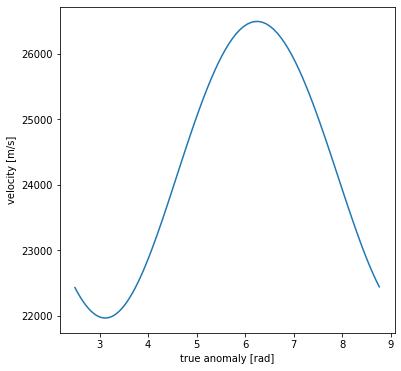

In [8]:
import matplotlib
matplotlib.use('TKAgg')

plot_velocity_mars()

## Plot of latent activations

In [ ]:
# The mean anomalies M_E and M_M of Earth and Mars, respectively.
import matplotlib
matplotlib.use('TKAgg')

fig = copernicus_latent_neurons(net,series_length = 50)

### Calculate L2-norm of error

In [ ]:
data, states = edc.copernicus_data(50, 50000)

In [ ]:
np.sqrt(net.run(data, net.recon_loss))